In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

import scvi
from scvi.external import SysVI
import anndata as ad

scvi.settings.seed = 0

/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/an

## process data

In [2]:
mouse = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_apoe/GSE225503_adapoe.h5ad')
human = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap_multi_region/hippocampus.h5ad')

In [3]:
mouse

AnnData object with n_obs × n_vars = 30868 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id'
    var: '_index', 'features'
    obsm: 'X_umap'

In [4]:
human

AnnData object with n_obs × n_vars = 221415 × 18914
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames'

### subset with overlapping genes

In [5]:
mouse_genes = list(mouse.var['features'])
mouse_genes = [item.upper() for item in mouse_genes]
mouse.var['upper_genes'] = mouse_genes

human_genes = set(human.var_names)

both_genes = human_genes.intersection(mouse_genes)
mouse = mouse[:, mouse.var['upper_genes'].isin(both_genes)]
human = human[:, human.var_names.isin(both_genes)]

In [6]:
mouse

View of AnnData object with n_obs × n_vars = 30868 × 15644
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id'
    var: '_index', 'features', 'upper_genes'
    obsm: 'X_umap'

In [7]:
human

View of AnnData object with n_obs × n_vars = 221415 × 15644
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames'

### normalize and select hvg

In [8]:
sc.pp.normalize_total(mouse, target_sum = 1e6)
sc.pp.log1p(mouse)
sc.pp.highly_variable_genes(mouse, subset = True, n_top_genes = 5000)

/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
sc.pp.normalize_total(human, target_sum = 1e6)
sc.pp.log1p(human)
sc.pp.highly_variable_genes(human, subset = True, n_top_genes = 5000)

/home/icb/zihe.zheng/miniconda3/envs/scvi2/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [10]:
mouse

AnnData object with n_obs × n_vars = 30868 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id'
    var: '_index', 'features', 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

In [11]:
human

AnnData object with n_obs × n_vars = 221415 × 5000
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [12]:
mouse_hvg = list(mouse.var['upper_genes'])

human_hvg = set(human.var_names)

both_hvg = human_hvg.intersection(mouse_hvg)
mouse = mouse[:, mouse.var['upper_genes'].isin(both_hvg)]
human = human[:, human.var_names.isin(both_hvg)]

In [13]:
mouse

View of AnnData object with n_obs × n_vars = 30868 × 1935
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id'
    var: '_index', 'features', 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

In [14]:
human

View of AnnData object with n_obs × n_vars = 221415 × 1935
    obs: 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    var: 'varnames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### set up batch key

In [15]:
mouse.obs['system'] = 'mouse'
human.obs['system'] = 'human'

mouse.obs['donor'] = 'mouse'
human.obs['donor'] = human.obs['projid']

/tmp/ipykernel_3048395/2807885086.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mouse.obs['system'] = 'mouse'
/tmp/ipykernel_3048395/2807885086.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  human.obs['system'] = 'human'


In [16]:
human = human[human.obs['major.celltype']=='Mic/Immune']

In [17]:
mouse.var_names = mouse.var.upper_genes

In [18]:
adata = ad.concat([mouse, human], join = 'outer', axis = 0)

In [19]:
adata

AnnData object with n_obs × n_vars = 54243 × 1935
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'system', 'donor', 'obsnames', 'lbl', 'U1', 'U2', 'barcode', 'rind', 'region', 'projid', 'is.doublet', 'col', 'tspcol', 'hcluster', 'hcelltype', 'hsubclass', 'major.celltype', 'minor.celltype', 'neuronal.layer', 'inh.subtype', 'neuronal.exttype', 'full.exttype', 'cell_type_high_resolution'
    obsm: 'X_umap'

In [20]:
mouse.obs.clust_id.value_counts()

clust_id
Microglia                           24750
Cd8 T Cells                          1411
Mature B Cells                        855
Monocytes                             581
Macrophages                           552
Late Neutrophils                      420
DP T Cells                            412
NK Cells                              336
Activated NK Cells                    334
Dendritic Cells                       300
F13a1+ Monocytes                      274
Immature B Cells                      183
Early Neutrophils                     178
ILC2s                                 121
GD T Cells                            114
Granulocyte-Monocyte Progenitors       24
Migratory DCs                          23
Name: count, dtype: int64

In [21]:
human[human.obs['major.celltype']=='Mic/Immune'].obs['cell_type_high_resolution'].value_counts()

cell_type_high_resolution
Mic P2RY12    19806
Mic TPT1       1253
CAMs            889
Mic DUSP1       768
T cells         608
Mic MKI67        51
Name: count, dtype: int64

## integration

In [ ]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    batch_key="system",
    categorical_covariate_keys=["donor"],
)

In [ ]:
# Example showing how to turn on embedding of all categorical covariates
model = SysVI(
    adata=adata,
    embed_categorical_covariates=True,
)

In [ ]:
# Initialise the model
model = SysVI(adata=adata)
# Train
max_epochs = 200
model.train(
    max_epochs=max_epochs, check_val_every_n_epoch=1, plan_kwargs={"z_distance_cycle_weight": 5}
)

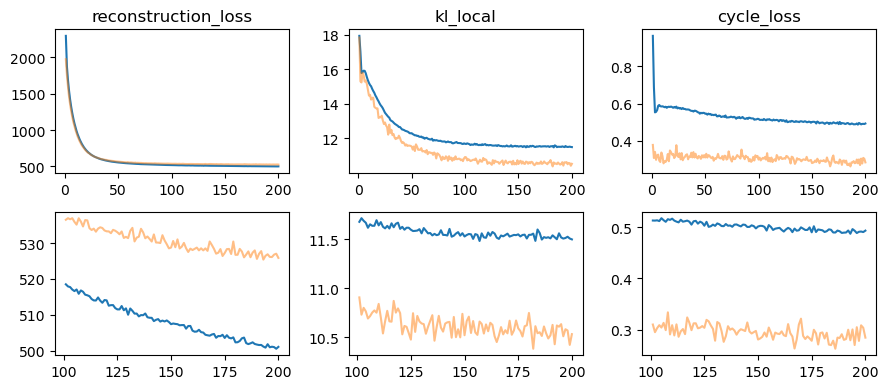

In [25]:
# Plot loses
# The plotting code below was specifically adapted to the above-specified model and its training
# If changing the model or training the plotting functions may need to be adapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot = 100

# Losses to plot
losses = [
    "reconstruction_loss_train",
    "kl_local_train",
    "cycle_loss_train",
]
fig, axs = plt.subplots(2, len(losses), figsize=(len(losses) * 3, 4))
for ax_i, l_train in enumerate(losses):
    l_val = l_train.replace("_train", "_validation")
    l_name = l_train.replace("_train", "")
    # Change idx of epochs to start with 1
    l_val_values = model.trainer.logger.history[l_val].copy()
    l_val_values.index = l_val_values.index + 1
    l_train_values = model.trainer.logger.history[l_train].copy()
    l_train_values.index = l_train_values.index + 1
    for l_values, c, alpha, dp in [
        (l_train_values, "tab:blue", 1, epochs_detail_plot),
        (l_val_values, "tab:orange", 0.5, epochs_detail_plot),
    ]:
        axs[0, ax_i].plot(l_values.index, l_values.values.ravel(), c=c, alpha=alpha)
        axs[0, ax_i].set_title(l_name)
        axs[1, ax_i].plot(l_values.index[dp:], l_values.values.ravel()[dp:], c=c, alpha=alpha)

fig.tight_layout()

In [29]:
# Get embedding - save it into X of new AnnData
embed = model.get_latent_representation(adata=adata)
embed = sc.AnnData(embed, obs=adata.obs)
# Make system categorical for plotting below
embed.obs["system"] = embed.obs["system"]

In [31]:
# Compute UMAP
sc.pp.neighbors(embed, use_rep="X")
sc.tl.umap(embed)

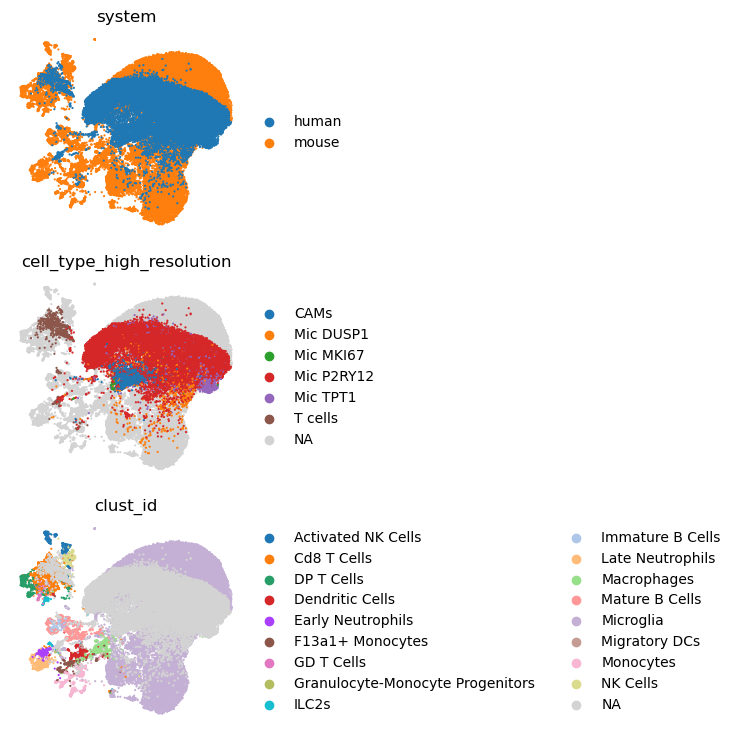

In [32]:

# Obs columns to color by
cols = ["system", "cell_type_high_resolution", 'clust_id']

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs, strict=False):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )